In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import h5py
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
def load_data(dataset_path):
    hf = h5py.File(dataset_path, 'r')
    inputs = hf.get('inputs')
    targets = hf.get('targets')
    
    inputs = np.array(inputs)
    targets = np.array(targets)
    hf.close()
    
    return inputs, targets

In [4]:
inputs, targets = load_data(r"/content/drive/MyDrive/Thesis/Datasets/music_dataset_augmented.h5")

In [5]:
print(inputs.shape)
print(targets.shape)

(19972, 130, 13)
(19972,)


In [6]:
inputs = inputs.reshape((inputs.shape[0], -1, 1))
print(inputs.shape)

(19972, 1690, 1)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
inputs = scaler.fit_transform(inputs.reshape(-1, inputs.shape[-1])).reshape(inputs.shape)

print(inputs.shape)

(19972, 1690, 1)


In [8]:
# train_test_split 80 10 10
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.2)
input_test, input_val, target_test, target_val   = train_test_split(input_test, target_test, test_size=0.5)

print(input_train.shape, input_test.shape, input_val.shape)

(15977, 1690, 1) (1997, 1690, 1) (1998, 1690, 1)


In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [10]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, n_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [11]:
input_shape = input_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.3,
    n_classes=len(np.unique(target_train))
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1690, 1)]    0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 1690, 1)     3585        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1690, 1)      0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 1690, 1)     2           ['dropout[0][0]']            

In [12]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/Thesis/Models/transformer_model1_plot.png')#, to_file='/content/drive/MyDrive/Thesis/Models/transformer_model1_plot.png'

In [13]:
early_stop  = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr   = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

hist = model.fit(
    input_train, target_train,
    validation_data=(input_val, target_val),
    epochs = 30,
    batch_size = 16,
    callbacks = [
        reduce_lr,
        early_stop
    ]
)

Epoch 1/30
999/999 [==============================] - 520s 507ms/step - loss: 1.7783 - sparse_categorical_accuracy: 0.3696 - val_loss: 1.5106 - val_sparse_categorical_accuracy: 0.4775 - lr: 1.0000e-04
Epoch 2/30
999/999 [==============================] - 508s 509ms/step - loss: 1.5326 - sparse_categorical_accuracy: 0.4519 - val_loss: 1.4009 - val_sparse_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/30
999/999 [==============================] - 506s 507ms/step - loss: 1.4425 - sparse_categorical_accuracy: 0.4873 - val_loss: 1.3459 - val_sparse_categorical_accuracy: 0.5295 - lr: 1.0000e-04
Epoch 4/30
999/999 [==============================] - 502s 502ms/step - loss: 1.3866 - sparse_categorical_accuracy: 0.5063 - val_loss: 1.3067 - val_sparse_categorical_accuracy: 0.5295 - lr: 1.0000e-04
Epoch 5/30
999/999 [==============================] - 502s 502ms/step - loss: 1.3422 - sparse_categorical_accuracy: 0.5275 - val_loss: 1.2806 - val_sparse_categorical_accuracy: 0.5410 - lr: 1.0000

In [14]:
error, acc = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {acc}")

63/63 [==============================] - 21s 336ms/step - loss: 1.0698 - sparse_categorical_accuracy: 0.6244
Test accuracy: 0.6244366765022278


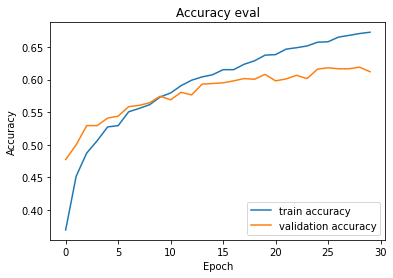

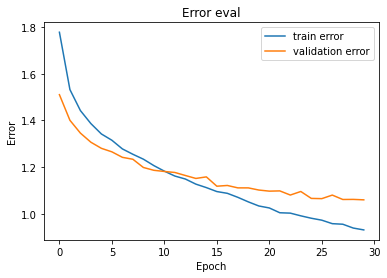

In [15]:
plt.plot(hist.history["sparse_categorical_accuracy"], label="train accuracy")
plt.plot(hist.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy eval")
plt.show()

plt.plot(hist.history["loss"], label="train error")
plt.plot(hist.history["val_loss"], label="validation error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.title("Error eval")
plt.show()

In [16]:
model.save('/content/drive/MyDrive/Thesis/Models/transformer_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/Models/Transformer_Fin_1003_ShiftTime_Dataset/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/Models/Transformer_Fin_1003_ShiftTime_Dataset/assets


In [17]:
import pickle
with open('/content/drive/MyDrive/Thesis/History/transformer_history.pkl', 'wb') as file_pi:
        pickle.dump(hist, file_pi)

INFO:tensorflow:Assets written to: ram://00a0cf81-aa10-4139-b2cd-23e12562342b/assets


INFO:tensorflow:Assets written to: ram://00a0cf81-aa10-4139-b2cd-23e12562342b/assets


In [18]:
with open('/content/drive/MyDrive/Thesis/History/transformer_history.pkl', 'rb') as f:
    saved_model = pickle.load(f)

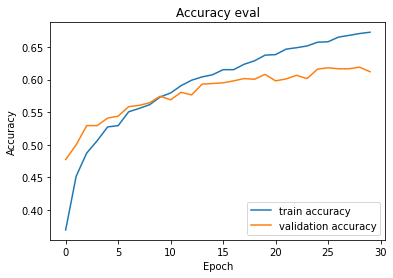

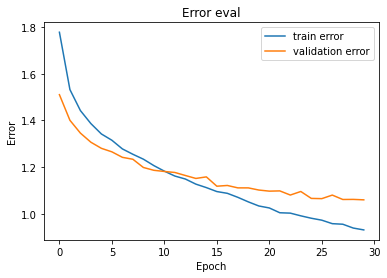

In [19]:
plt.plot(saved_model.history["sparse_categorical_accuracy"], label="train accuracy")
plt.plot(saved_model.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy eval")
plt.show()

plt.plot(saved_model.history["loss"], label="train error")
plt.plot(saved_model.history["val_loss"], label="validation error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.title("Error eval")
plt.show()